# Kelly criterion return-vol tradeoff
Examining the tradeoff between returns and volatility when using the Kelly criterion to size bets.

The Kelly criterion defines an optimal betsize - one that maximises the log growth rate across a series of bets. 

In the simple case, we consider a fixed probability of winning and a fixed price (thus assuming some fixed price).

In [2]:
from IPython.display import display, Math, Latex

Kelly maximises the log growth rate as the returns for a series of sequential bets are multiplicative. 
So we can take the exponential of the log returns.

For p = prob of win, b = price, the expected log return is

In [3]:
display(Math(r'E(log(X))=plog(1+bx)+(1−p)log(1−x)'))

<IPython.core.display.Math object>

Maximising gives us a Kelly bet size of:

In [4]:
display(Math(r'(pb - (1-p)) / b'))

<IPython.core.display.Math object>

There's a nice heuristic derivation that I always liked, here https://en.wikipedia.org/wiki/Kelly_criterion#Proof (calculate amount won with optimal size and introdue a delta to size, differentiate w.r.t. delta and show delta = 0 at the max).

You could also approximate by taking the first two terms of the Taylor expansion of log(1+x), and maximising. This may or may not be a valid approximation, depending on the distribution of returns, e.g. it would be inaccurate if the returns are positively skewed.

In [5]:
display(Math(r'log(1+x) = \sum_{n=1}^{\infty} (-1)^{n+1} \dfrac{x^n}n, \left|x\right|  \leqslant 1, x \neq -1'))

<IPython.core.display.Math object>

## Simulation
For our simulation, we select a fixed predicted %, assume a fixed 3% edge on the market and simulate multiple Kelly bets. We then select another fixed predicted %, and re-run the simulation.

We calculate mean and std of returns, though we could find the expected rate of return by using the exponential
of the expected log return (as described here http://www.elem.com/~btilly/kelly-criterion/)

Measuring the variance of returns is important as appetite for vol varies (thus it may make sense to bet less than the theoretical optimal amount), though we can't ever go broke (assuming we have a positive edge on the market), as The Kelly Criterion prescribes a bet of a proportion of the bankroll.

The log of returns over a large sample is normally distributed, by the Central Limit Theorem.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# parameterisation
start_bankroll = 10000
trade_count = 10000
# we assume our prediction is perfect
win_prob = 0.53 
# assume 3% edge
price = 0.50
dec_price = 1/price - 1

In [8]:
def run_trials(win_prob, bankroll, trade_count, dec_price):
    std = []
    mean = []
    for y in range(0,50):
        bankroll = []
        returns = []
        df = pd.DataFrame()
        for i in range(0, trade_count):
            if i == 0:
                step_bankroll = start_bankroll
            else:
                step_bankroll = bankroll[i-1]
            kelly_prop = (win_prob * (dec_price+1) - 1) / dec_price
            win = np.random.rand() <= win_prob
            trade_size = kelly_prop*step_bankroll
            profit = dec_price*trade_size if win else -1*trade_size
            returns.append(profit/step_bankroll)
            step_bankroll += profit
            bankroll.append(step_bankroll)

        df['bankroll'] = bankroll
        df['return'] = returns
        std.append(np.std(df['return']))
        mean.append(np.mean(df['return']))
        plt.plot(df['bankroll'][0:1000])    

    var = [i**2 for i in std]
    av_var = sum(var) / len(var)
    av_down_var =  var[var < 0].sum() / len(var)
    av_down_std = av_down_var ** 0.5
    av_std = av_var**0.5
    av_mean = np.mean(mean)
# turn on plot to view individual trial results, can also plot std for each trial - and see that Kelly results in
# a highly volatile return. this can be temped (at a cost in terms of expected return) by using fractional Kelly
# i.e. applying a fixed fractional multiplier to the Kelly-prescribed bet amount. 1/2 is a commonly used multiplier.
#     plt.show()
    return {'win_prob': win_prob,'std': av_std, 'down_std': av_down_std, 'mean': av_mean}

In [9]:
result = pd.DataFrame()
for x in np.arange(0.05, 1, 0.05):
    start_bankroll = 10000
    trade_count = 10000
    win_prob = x
    # assume 3% edge
    price = x - 0.03
    dec_price = 1/price - 1
    result = result.append(run_trials(win_prob, start_bankroll, trade_count, dec_price), ignore_index=True)

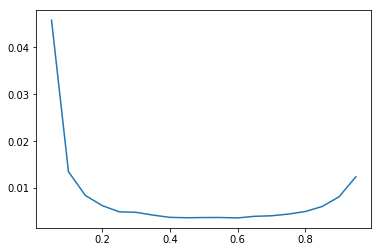

In [23]:
plt.plot(result['win_prob'], result['mean'])
plt.show()

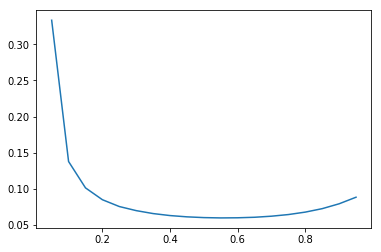

In [24]:
plt.plot(result['win_prob'], result['std'])
plt.show()

In [25]:
result
# we have a fairly large sample, and if we calculate e^E(log(x)) using our parameter values as described above,
# we see mean return is close to the expected return (at p=0.83, e^E(log(x)) = 0.00345, at p=0.53, e^E(log(x)) = 0.00190)

,down_std,mean,std,win_prob,sharpe_ratio,sortino_ratio
0,0.048104,0.045768,0.333266,0.05,0.137333,0.951448
1,0.018973,0.013506,0.137815,0.10,0.098001,0.711839
2,0.014436,0.008437,0.101354,0.15,0.083248,0.584481
3,0.011845,0.006268,0.084960,0.20,0.073780,0.529175
4,0.010737,0.004955,0.075530,0.25,0.065597,0.461445
5,0.009908,0.004841,0.069866,0.30,0.069287,0.488590
6,0.009328,0.004248,0.065791,0.35,0.064572,0.455430
7,0.008946,0.003770,0.063029,0.40,0.059820,0.421473
8,0.008663,0.003685,0.061265,0.45,0.060156,0.425428
9,0.008516,0.003731,0.060214,0.50,0.061959,0.438095


In [26]:
#sharpe ratios (assume rf = 0)
result['sharpe_ratio'] = result['mean'] / result['std']

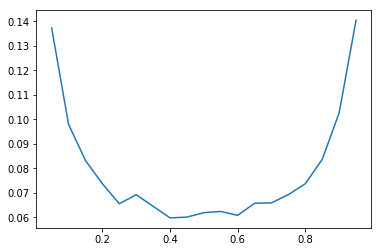

In [27]:
plt.plot(result['win_prob'], result['sharpe_ratio'])
plt.show()

This makes sense as our returns go exponential at both tails:

The sharpe ratio goes exponential at the left tail as our model assumption that we have a 3% edge (or any edge) on the price implies that as our predicted prob -> 0.03, prob implied by price -> 0, so price -> infinity, and we have infinite expected return as E[x] = price*trade_size if win else -1*trade_size, and for any finite trade size, E[x] -> infinity.

Similarly, the sharpe ratio goes exponential at the right tail as again our model assumption that we have a 3% edge (or any edge) implies that as prob implied by price -> 0.97, our predicted prob -> 1. and so E[x] -> price * trade_size as prob(win) -> 1. kelly criterion bet size is to bet the whole bankroll (as return is certain), and as result is certain, std = 0 (no risk - o -> u/sigma -> infinity

To increase our expected return, we must move away from bets around the 50% prediction, and in return our vol also increases. We'll look at the sortino ratio to discover the shape of this vol - upside vol is positive. here downside vol has the same behaviour as overall vol


In [28]:
# sortino ratio (downside vol only - as upside vol is desirable - Sharpe punishes upside vol)

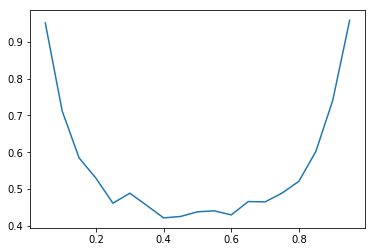

In [29]:
result['sortino_ratio'] = result['mean'] / result['down_std']
plt.plot(result['win_prob'], result['sortino_ratio'])
plt.show()

In [30]:
result

,down_std,mean,std,win_prob,sharpe_ratio,sortino_ratio
0,0.048104,0.045768,0.333266,0.05,0.137333,0.951448
1,0.018973,0.013506,0.137815,0.10,0.098001,0.711839
2,0.014436,0.008437,0.101354,0.15,0.083248,0.584481
3,0.011845,0.006268,0.084960,0.20,0.073780,0.529175
4,0.010737,0.004955,0.075530,0.25,0.065597,0.461445
5,0.009908,0.004841,0.069866,0.30,0.069287,0.488590
6,0.009328,0.004248,0.065791,0.35,0.064572,0.455430
7,0.008946,0.003770,0.063029,0.40,0.059820,0.421473
8,0.008663,0.003685,0.061265,0.45,0.060156,0.425428
9,0.008516,0.003731,0.060214,0.50,0.061959,0.438095
